<a href="https://colab.research.google.com/github/jerjesporlles/GRC/blob/main/GR_Workshop_Day1_SpatialStatisticsKriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variogram, Kriging, Random Conditioned Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1PLs5nUhGXgCUvPuTvswiqsx3NLxRVucq#scrollTo=b1jAiODQor-k)

In this Colab notebook:
Goals 
- quantify how a property (here temperature) changes in space (variograms)
- use this to make interpolation maps (Kriging) that account for this spatial correlation 

We will repeat these steps twice

  1) calculate experimental variogram (from the data) . . .

  2) fit a modeled (continuous) variogram for all distances ---
 
- Variogram exploration & calculation
    - Which directions have highest spatial correlation?
- Kriging spatial interpolation
    - spatial interpolation that reproduces observed data & uses the variogram to impart directional correlation
- Quasi-stochastic modeling
- 3D Kriging 
- <font color=orange> 3D visualization with PyVista, doesn't work well on colab </font>

Through all of this you'll be introduced to manipulating data and plotting with Python & Colab.

In [ ]:
# I'm running this notebook in my local conda environment as well so I set up a check for certain cells 
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1OQSOpLykiMW_t6olD-pP1lfiNIPpxckz/preview" width="640" height="480" allow="autoplay"></iframe>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import pandas as pd

In [ ]:
import os
import subprocess

try:
    import leafmap
except ImportError:
    print('Installing leafmap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'leafmap'])

import leafmap.foliumap as leafmap 
import folium

Installing leafmap ...


### Let's get some data. 
This command (notice the `!` is a system command so like you are in shell window) will put the file in your current colab directory (*not* your personal google drive)

`wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O FILENAME4Saving`

In [ ]:
# https://drive.google.com/file/d/1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc/view?usp=sharing
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ylm9aAwu5FhsIJmYMRZ_FcRIX091Liqc' -O WGC_temp.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV'  -O GSV_2mtemp.csv

--2022-03-14 16:03:26--  https://docs.google.com/uc?export=download&id=1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV
Resolving docs.google.com (docs.google.com)... 172.217.0.46, 2607:f8b0:4004:832::200e
Connecting to docs.google.com (docs.google.com)|172.217.0.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/to78fv9ece36ifqgthbcppj7i76ue6n5/1647273750000/03887978596655340594/*/1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV?e=download [following]
--2022-03-14 16:03:27--  https://doc-04-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/to78fv9ece36ifqgthbcppj7i76ue6n5/1647273750000/03887978596655340594/*/1PJyDdJHMnCx0n2duwhAuAdZZaMzw36vV?e=download
Resolving doc-04-0o-docs.googleusercontent.com (doc-04-0o-docs.googleusercontent.com)... 172.217.0.33, 2607:f8b0:4004:800::2001
Connecting to doc-04-0o-docs.googleusercontent.com (doc-04-0o-docs.googleusercontent.c

You can see what's in the temporary Colab directory. Also see if you click the folder icon on the far left of your screen.

In [ ]:
!ls -ltr 

total 8
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data
-rw-r--r-- 1 root root 1167 Mar 14 16:03 GSV_2mtemp.csv


Now we use some pandas to read the csv file into a DataFrame

In [ ]:
if IN_COLAB:
#     temp_df = pd.read_csv('/content/WGC_temp.csv')
    temp_df = pd.read_csv('GSV_2mtemp.csv')
else:
# !ls ../../Colab\ Notebooks/GRC_StudentsWorkshop/Public
#     temp_df = pd.read_csv('../../Colab Notebooks/GRC_StudentsWorkshop/Public/WGC_data.csv')
    temp_df = pd.read_csv('GSV_xy2mCorr.csv')


In [ ]:
temp_df

,Unnamed: 0,index,x_easting,y_northing,2mCorr,latitude,longitude
0,0,0,329261.0,4427358.0,9.5,39.979153,-118.999550
1,1,1,329206.0,4426901.0,8.4,39.975026,-119.000074
2,2,2,330362.0,4427475.0,9.7,39.980428,-118.986694
3,3,3,331695.0,4428308.0,8.2,39.988195,-118.971307
4,4,4,331023.0,4429089.0,9.0,39.995093,-118.979377
5,5,5,330109.0,4430126.0,9.8,40.004247,-118.990348
6,6,6,329632.0,4431139.0,9.0,40.013273,-118.996199
7,7,7,328876.0,4430727.0,9.5,40.009410,-119.004943
8,8,8,328724.0,4429683.0,10.0,39.999979,-119.006448
9,9,9,329652.0,4428857.0,9.4,39.992729,-118.995366


In [ ]:
temp_df = temp_df.drop(columns='Unnamed: 0') # get rid of junk column
temp_df.head()

,index,x_easting,y_northing,2mCorr,latitude,longitude
0,0,329261.0,4427358.0,9.5,39.979153,-118.999550
1,1,329206.0,4426901.0,8.4,39.975026,-119.000074
2,2,330362.0,4427475.0,9.7,39.980428,-118.986694
3,3,331695.0,4428308.0,8.2,39.988195,-118.971307
4,4,331023.0,4429089.0,9.0,39.995093,-118.979377


Let's check the summary statistics of this little dataset

In [ ]:
temp_df.describe()

,index,x_easting,y_northing,2mCorr,latitude,longitude
count,17.000000,17.000000,1.700000e+01,17.000000,17.000000,17.000000
mean,8.000000,329515.058824,4.429642e+06,9.052941,39.999766,-118.997176
std,5.049752,871.281131,2.179169e+03,0.676496,0.019578,0.010362
min,0.000000,328478.000000,4.426901e+06,7.600000,39.975026,-119.010178
25%,4.000000,328876.000000,4.427475e+06,8.500000,39.980428,-119.004943
50%,8.000000,329261.000000,4.429089e+06,9.200000,39.995093,-118.999550
75%,12.000000,329727.000000,4.431139e+06,9.500000,40.013273,-118.995366
max,16.000000,331695.000000,4.433631e+06,10.000000,40.035628,-118.971307


Plot what it looks like in space

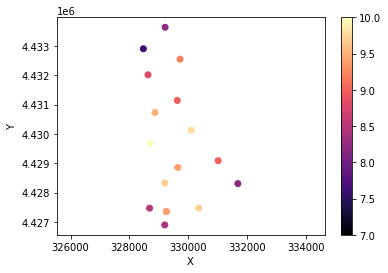

In [ ]:
plt.scatter(temp_df['x_easting'],temp_df['y_northing'],cmap='magma',c=temp_df['2mCorr'],vmin=7, vmax=10)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

<font size = 5> Where is this data? 
What did Connor just teach us?! very cool

In [ ]:
m = leafmap.Map(center=(40,-118), zoom=8)
m.add_heatmap(
    temp_df,
    longitude="longitude", latitude="latitude",
    value='2mCorr',
    name="Heat map",
    radius=10,
    cmap='magma'
)
m

# Install packages for geostatistical tools
[Here](https://geostat-framework.readthedocs.io/projects/gstools/en/stable/) is the quickstart guide for this package

In [ ]:
if IN_COLAB:
  !pip install gstools

     |████████████████████████████████| 1.3 MB 25.0 MB/s 
     |████████████████████████████████| 167 kB 67.9 MB/s 
     |████████████████████████████████| 45 kB 4.5 MB/s 
     |████████████████████████████████| 224 kB 72.2 MB/s 
     |████████████████████████████████| 51 kB 8.7 MB/s 


In [ ]:
import gstools as gs

[PyVista](https://docs.pyvista.org/getting-started/installation.html) has awesome plotting tools. [GSTools](https://pypi.org/project/gstools/) is the library we will use to demonstrate some geostatistical concepts.



# Experimental Variogram calculation
First let's establish a variable of *where* the data are (position: `pos`) and the data value (value: `val`) which will be used for *conditioning* the geostatistical interpolation.

In [ ]:
temp_cond_pos = [[temp_df.x_easting], [temp_df.y_northing]]
temp_cond_val = temp_df['2mCorr']
print(np.shape(temp_cond_val))
print(np.shape(temp_cond_pos))
temp_cond_pos

(17,)
(2, 1, 17)


[[0     329261.0
  1     329206.0
  2     330362.0
  3     331695.0
  4     331023.0
  5     330109.0
  6     329632.0
  7     328876.0
  8     328724.0
  9     329652.0
  10    329207.0
  11    328690.0
  12    328635.0
  13    328478.0
  14    329727.0
  15    329218.0
  16    329261.0
  Name: x_easting, dtype: float64], [0     4427358.0
  1     4426901.0
  2     4427475.0
  3     4428308.0
  4     4429089.0
  5     4430126.0
  6     4431139.0
  7     4430727.0
  8     4429683.0
  9     4428857.0
  10    4428330.0
  11    4427472.0
  12    4432012.0
  13    4432898.0
  14    4432544.0
  15    4433631.0
  16    4427358.0
  Name: y_northing, dtype: float64]]

This function calculates the difference of pairs of data at different distances. 

`gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)`

which is this calculation
 <font size="5">   
 $\gamma(h) = \frac{1}{2N(h)}\Sigma_{i=1}^{N(h)} [z(u] - z(u+h)]^2$ 
    </font>

In [ ]:
bin_center, gamma, omni_counts = gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)


Here we plot the resulting *dissimiliarity* of the data at different distances.

Text(0.5, 1.0, 'Experimental variogram $\\gamma$')

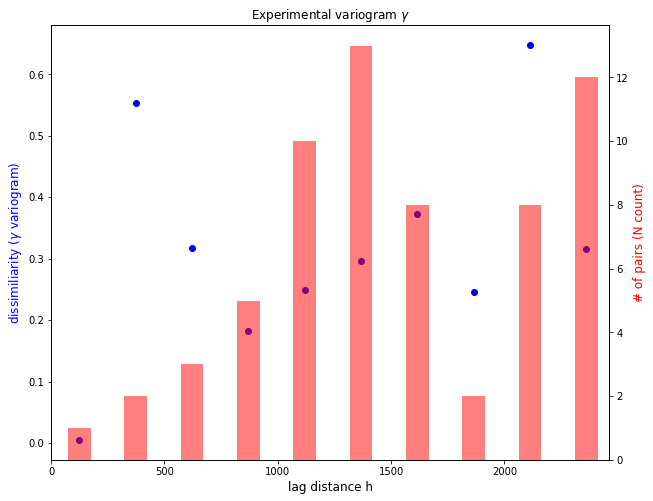

In [ ]:
fig, axes = plt.subplots(figsize=(10,8))
axes2 = axes.twinx()
# Eperimental variogram (from the data)
axes.scatter(bin_center, gamma,c='b', label='omni')
axes2.bar(bin_center,omni_counts, width=100, color='red',alpha=0.5)

#axes.legend()
axes.set_xlabel('lag distance h', fontsize=12)
axes.set_ylabel('dissimiliarity ($\gamma$ variogram)', fontsize=12, color='blue')
axes2.set_ylabel('# of pairs (N count)', fontsize=12, color='red')
axes.set_xlim([0, np.max(bin_center)+100])
# axes.set_ylim([0, 1])
gammastring='$\gamma$'
titletxt = 'Experimental variogram '+gammastring

axes.set_title(titletxt)

These are the $h$'s

In [ ]:
bin_center

array([ 124.32259672,  372.96779016,  621.61298361,  870.25817705,
       1118.90337049, 1367.54856394, 1616.19375738, 1864.83895082,
       2113.48414426, 2362.12933771])

## 3 main parts to the variogram:

- Range
- Sill
- Nugget

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1TTK0IsW5vZS0ERQV5f6LXRAXjuB81Frj/preview" width="640" height="480" allow="autoplay"></iframe>

# Why do we need variogram modeling?
(1) Estimation (Kriging) requires that variogram is known for all distances

(2) There are limitation as to what mathematical models can be used 

(3) Modeling smoothes the fluctuations in the data

(4) Modeling often forces one to search for a geological interpretation

## Which variogram model type is best to use?
This cell is looping through the different types of variograms which all have a bit of different behavior at different lag distances ($h$).

$a$ is the effective range : the distance at which there's no longer anycorrelation in that direction.

For example:
- Exponential: $Exp(h) = 1 -exp(-3h/a)$
- Spherical: $Sph(h) = 1.5(h/a) - 0.5(h/a)^3$ 
- Gaussian: $Gaus(h) = 1 -exp(-3(h/a)^2)$

Exponential(dim=2, var=0.296, len_scale=2.05e+02, nugget=0.05)
Spherical(dim=2, var=0.294, len_scale=4.28e+02, nugget=0.05)
Gaussian(dim=2, var=0.298, len_scale=1.9e+02, nugget=0.05)


Text(0, 0.5, 'Dissimiliarity (variogram value)')

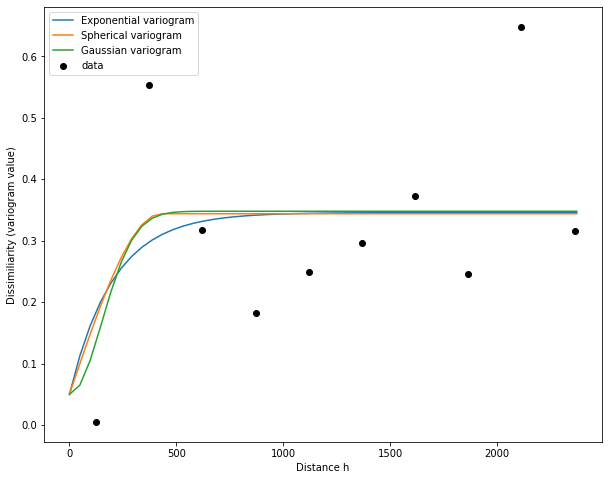

In [ ]:
varmodeltypes = {
  "Exponential": gs.Exponential,
  "Spherical": gs.Spherical,
  "Gaussian": gs.Gaussian
}

scores = {}

plt.figure(figsize=(10,8))
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram, with the same nugget
for model in varmodeltypes:
    fit_model = varmodeltypes[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True,nugget=0.05)
    fit_model.plot(x_max=np.max(bin_center)+10, ax=ax)
    scores[model] = r2
    print(fit_model)

ax.set_xlabel('Distance h')
ax.set_ylabel('Dissimiliarity (variogram value)')

<font color=red size=6> Do you see where the nugget was set in the above code?

We don't have to do that, we can let it fit it. Same for range (`len_scale`, `sill`)...

Which one of the three variogram model types fit the data best, according to the $R^2$ score?

In [ ]:
import operator
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_scores)

[('Gaussian', 0.29214091293836997), ('Spherical', 0.2609393239092789), ('Exponential', 0.19242238271503176)]


# Choose variogram model type, then fit the experimental data for each direction
The `Gaussian` variogram has the best $R^2$ score, but feel free to try others.

<font color=red> Why else do you think Gaussian may be a good choice here given 1) the property we are modeling 2) the behavior of the 3 models?

In [ ]:
bin_center, gamma, omni_counts = gs.vario_estimate((temp_cond_pos), temp_cond_val, return_counts=True)

vario_model = gs.Gaussian(dim=2) #Spherical(dim=2)

vario_model.fit_variogram(bin_center, gamma, nugget=0.02)

vario_model

Gaussian(dim=2, var=0.328, len_scale=1.85e+02, nugget=0.02)

Now let's plot the experimental variogram (raw from the data, scatter plot) and the modeled variogram.

Text(0.5, 1.0, 'Gaussian(dim=2, var=0.328, len_scale=1.85e+02, nugget=0.02) & Experimental variogram')

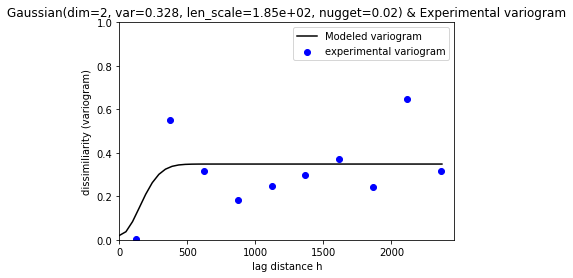

In [ ]:
fig, axes = plt.subplots()#figsize=(10,8))
# Modeled (fitted) variogram : continuous
vario_model.plot(c='k', label='Modeled variogram',ax=axes,x_max=np.max(bin_center)+10)
# Eperimental variogram (from the data)
axes.scatter(bin_center, gamma,c='b', label='experimental variogram')

axes.legend()
axes.set_xlabel('lag distance h')
axes.set_ylabel('dissimiliarity (variogram)')
axes.set_xlim([0, np.max(bin_center)+100])
axes.set_ylim([0, 1])
titletxt = str(vario_model)+' & Experimental variogram'
axes.set_title(titletxt)

# Plot with different inferred ranges of variogram of spatial continuity

[This Colab demo](https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=_00aYIMEXVGS) will explain how the plotting widgets (tabs) work.

In [ ]:
if IN_COLAB:
    from google.colab import widgets

# 2D Kriging: spatial interpolation with the $\gamma$ 

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1TmAbNB8EPVaVfgDkfD_3b7nwH29MTo5E/preview" width="640" height="480" allow="autoplay"></iframe>

First, define the regular grid on which the interpolation will be done. Check how big it is.

In [ ]:
gridx = np.arange(np.min(temp_df.x_easting)-500, np.max(temp_df.x_easting)+500,10)
gridy = np.arange(np.min(temp_df.y_northing)-500, np.max(temp_df.y_northing)+500,10)
np.shape(gridx), np.shape(gridy)

((422,), (773,))

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import mpl_toolkits.axisartist.floating_axes as floating_axes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

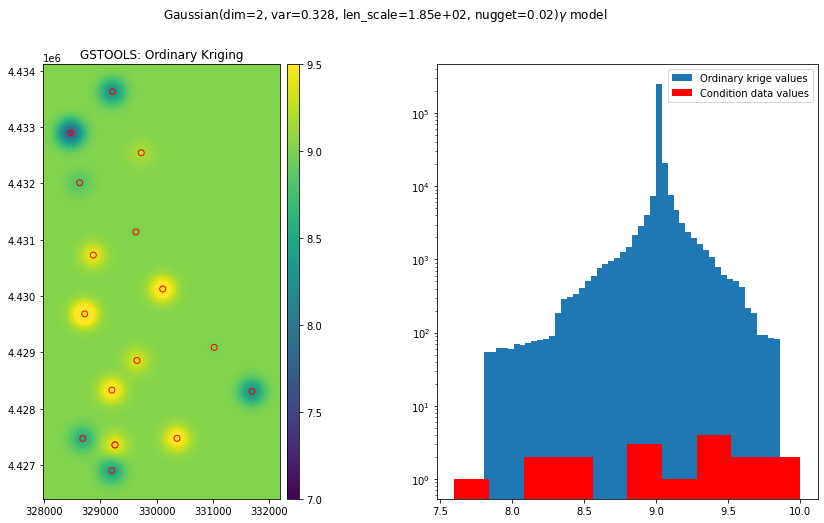

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

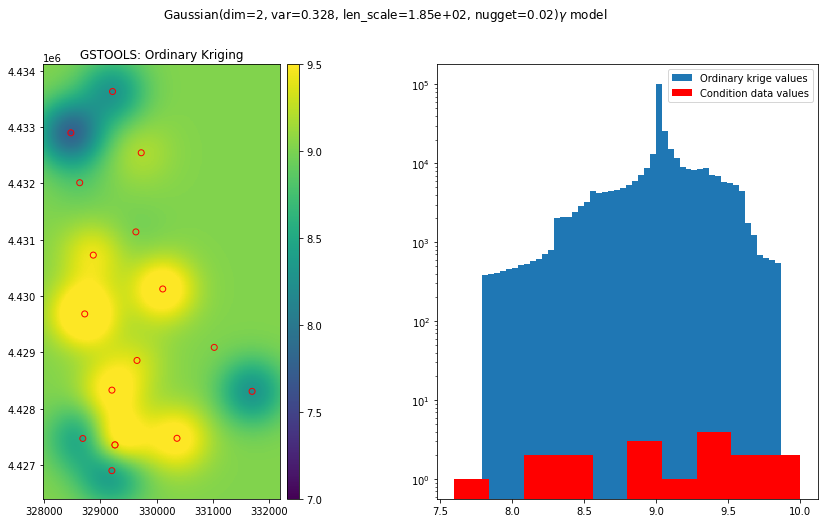

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

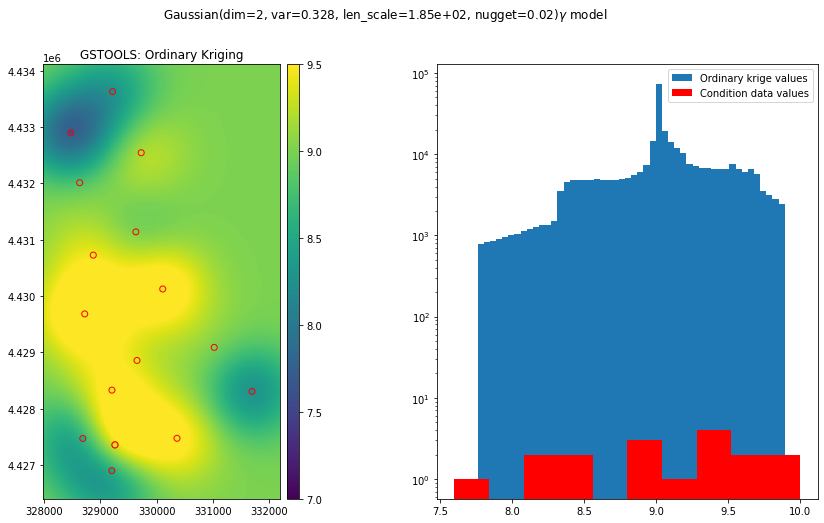

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

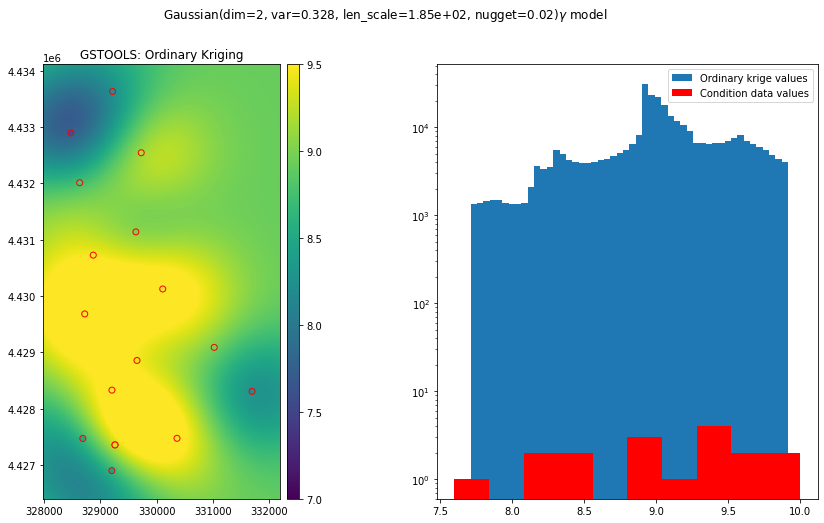

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

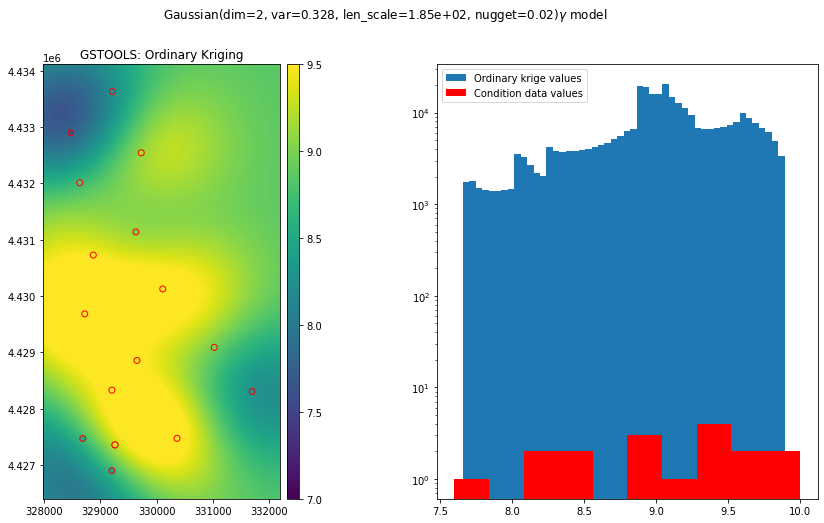

<IPython.core.display.Javascript object>

In [ ]:
diff_ranges = [200,500, 700, 1000, 1200] 

if IN_COLAB:
    tb3 = widgets.TabBar(['2d Kriging with this range  '+str(diff_ranges[i]) for i in range(np.shape(diff_ranges)[0])])
else:
    ## local conda
    fig, myax = plt.subplots(figsize=[10,15],ncols = 2, nrows = np.shape(diff_ranges)[0])
# 

for i in range(np.shape(diff_ranges)[0]):
    
    gauss2d_model= gs.Gaussian(dim=2)
    gauss2d_model.fit_variogram(bin_center, gamma, len_scale=diff_ranges[i], nugget=0.02)

    #print('made with this variogram model: ',gauss2d_model)
    krigeOK = gs.krige.Ordinary(gauss2d_model, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
    krigeOK.structured((gridx, gridy))

    my_vmin = 7 # 10
    my_vmax = 9.5 #90

    ## Only select the first 2 tabs, and render others in the background.
    if IN_COLAB:

        ## Only select the first 2 tabs, and render others in the background.
        with tb3.output_to(i, select=(i < 2)):

          f, myax = plt.subplots(figsize=[15, 8], nrows=1, ncols=2)
          myax = myax.flatten()
          # plot the result
          phandle =myax[0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[0].set_title('GSTOOLS: Ordinary Kriging')
          myax[0].axis('equal')
          divider = make_axes_locatable(myax[0])  
          cax = divider.append_axes("right", size="5%", pad=0.1)  
          cb=plt.colorbar(phandle, cax=cax)

          myax[1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[1].set_yscale('log')
          myax[1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          plt.suptitle(titletxt)
    else:
          # plot the result
          phandle =myax[i,0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[i,0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[i,0].set_title('GSTOOLS: Ordinary Kriging')
          myax[i,0].axis('equal')
          divider = make_axes_locatable(myax[i,0])  
          cax = divider.append_axes("right", size="5%", pad=0.1)  
          cb=plt.colorbar(phandle, cax=cax)

          myax[i,1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[i,1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[i,1].set_yscale('log')
          myax[i,1].legend()

          titletxt = str(diff_ranges[i])+' range $\gamma$'
          myax[i,0].set_title(titletxt,fontsize=12)
          plt.tight_layout()

Ok, hopefully that helped you see the effect of the range, but honestly, they look like the "heatmap" of the folium figure above...concentric circles around the measured temperature points.  

We we calculated the **omni** directional variogram above. <font color=red> What should we do differently if we want to see if there's a direction with higher spatial correlation in the data?

# Directional Variograms 

## Angles: Radian
Let's compute the variabilty in directions.

We need the directions in radians, not angles.

| Degree  | Radians  |  Map |
|:-:|:-:|:-:|
| 0  | 0  | East - West |
| 45  | 0.78539816  | North East - South West |
| 90  | 1.57079633  | North - South |
| 135  | 2.35619449  | North West - Sout East |
| 180  | 3.14159265  | East - West |

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1Tc9aVQpaa7pW9L-L4xhljOFWDW2WesBR/preview" width="340" height="280" allow="autoplay"></iframe>

In [ ]:
mydegrees = [0,45,90,135,180]
myrads=np.radians(mydegrees); myrads

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265])

In [ ]:
bin_center, gamma_0, count_0 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0,return_counts=True,angles_tol=np.pi / 10) 
bin_center, gamma_45, count_45 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=0.78539816,return_counts=True,angles_tol=np.pi / 10)
bin_center, gamma_90, count_90 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=1.57079633,return_counts=True,angles_tol=np.pi / 10)
bin_center, gamma_135, count_135 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=2.35619449,return_counts=True,angles_tol=np.pi / 10)
bin_center, gamma_180, count_180 = gs.vario_estimate((temp_cond_pos), temp_cond_val,angles=3.14159265,return_counts=True,angles_tol=np.pi / 10)

#?gs.vario_estimate
print('gamma_0',gamma_0)
print('gamma_90',gamma_90)
print('gamma_135',gamma_135)
print('gamma_180',gamma_180)

gamma_0 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]
gamma_90 [0.005      0.5525     0.         0.26166667 0.125      0.37
 0.0025     0.         1.14333333 0.2175    ]
gamma_135 [0.005      0.         0.         0.005      0.25       0.11333333
 0.045      0.         0.98       0.59333333]
gamma_180 [0.005  0.     0.4525 0.     0.0325 0.46   0.72   0.     0.72   0.5   ]


Plot those *experimental variograms* $\gamma$

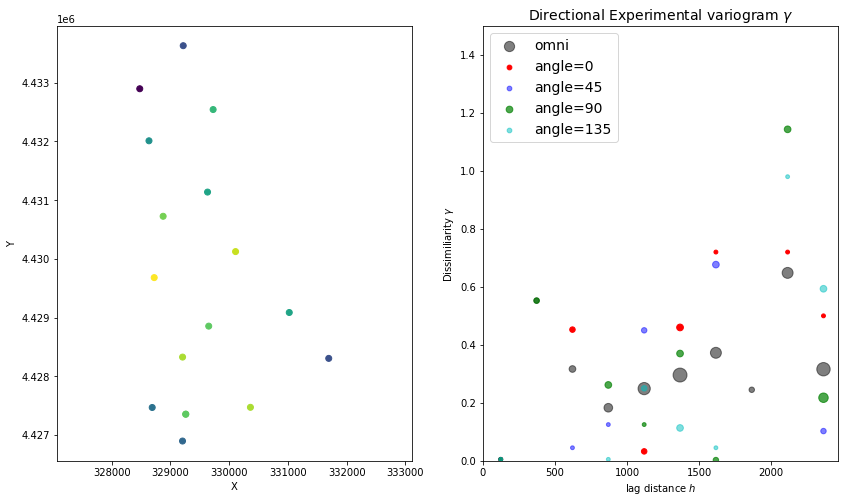

In [ ]:
fig, axes = plt.subplots(figsize=(14,8),ncols=2)

axes[0].scatter(temp_df['x_easting'],temp_df['y_northing'],c=temp_df['2mCorr']) #,vmin=7, vmax=10)
axes[0].axis('equal')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[1].set_title('Granite Springs 2m Temperature', fontsize=14)


count_size_multiplier = 15

axes[1].scatter(bin_center, gamma,c='k',s=omni_counts*count_size_multiplier, label='omni',alpha=0.5)
axes[1].scatter(bin_center, gamma_0,c='r', s=count_0*count_size_multiplier,label='angle=0')
axes[1].scatter(bin_center, gamma_45,c='b',label='angle=45',s=count_45*count_size_multiplier,alpha=0.5)
axes[1].scatter(bin_center, gamma_90,c='g',label='angle=90',s=count_90*count_size_multiplier,alpha=0.7)
axes[1].scatter(bin_center, gamma_135,c='c',label='angle=135',s=count_135*count_size_multiplier,alpha=0.5)
axes[1].legend()
axes[1].set_xlabel('lag distance')
axes[1].set_xlim([0, np.max(bin_center)+100])
axes[1].set_ylim([0, 1.5])
axes[1].set_xlabel('lag distance $h$')
axes[1].set_ylabel('Dissimiliarity $\gamma$')
titletxt = 'Directional Experimental variogram $\gamma$'
axes[1].set_title(titletxt, fontsize=14)
axes[1].legend(fontsize=14)

In [ ]:
print('0 East\t\t',count_0, np.sum(count_0))
print('45 NE-SW\t',count_45,np.sum(count_45))
print('90 N-S\t\t',count_90,np.sum(count_90))
print('135 NW-SE\t',count_135,np.sum(count_135))

0 East		 [1 0 2 0 2 3 1 0 1 1] 11
45 NE-SW	 [1 0 1 1 2 0 3 0 0 2] 10
90 N-S		 [1 2 0 3 1 3 2 0 3 6] 21
135 NW-SE	 [1 0 0 1 2 3 1 0 1 3] 12


<font size=5> We can sort of see that there are different *dissimiliarities* in different directions. Let's see what the algorithm fits as the `len_scale` or range for each one, e.g. calculate the variogram for each of these angles.

## Initiate the MODELED directional variograms:

In [ ]:

vario_model_0 = gs.Gaussian(dim=2,angles=myrads[0],len_scale=[2.49e+03,6.11e+02])
vario_model_45 =gs.Gaussian(dim=2,angles=myrads[1],len_scale=[2.49e+03,6.11e+02])
vario_model_90 =gs.Gaussian(dim=2,angles=myrads[2],len_scale=[2.49e+03,6.11e+02]) 
vario_model_135 =gs.Gaussian(dim=2,angles=myrads[3],len_scale=[2.49e+03,6.11e+02])
vario_model_180 =gs.Gaussian(dim=2,angles=myrads[4],len_scale=[2.49e+03,6.11e+02])

vario_model_0.fit_variogram(bin_center, gamma_0, nugget=0.02) 
vario_model_90.fit_variogram(bin_center, gamma_90, nugget=0.02) 
vario_model_45.fit_variogram(bin_center, gamma_45, nugget=0.02) 
vario_model_135.fit_variogram(bin_center, gamma_135, nugget=0.02, sill=1.0)
vario_model_180.fit_variogram(bin_center, gamma_180, nugget=0.02) 

({'len_scale': 1370.2745709387445, 'nugget': 0.02, 'var': 0.575412082712613},
 array([[1.75124960e-01, 4.14867714e+02],
        [4.14867714e+02, 1.14484361e+06]]))

vario_model_0 Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02)
vario_model_45 Gaussian(dim=2, var=0.164, len_scale=6.11e+02, nugget=0.02, angles=[0.785])
vario_model_90 Gaussian(dim=2, var=0.594, len_scale=1.88e+03, nugget=0.02, angles=[1.57])
vario_model_135 Gaussian(dim=2, var=0.98, len_scale=2.49e+03, nugget=0.02, angles=[2.36])
vario_model_180 Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02, angles=[3.14])


Text(0.5, 1.0, 'Modeled & Experimental variograms')

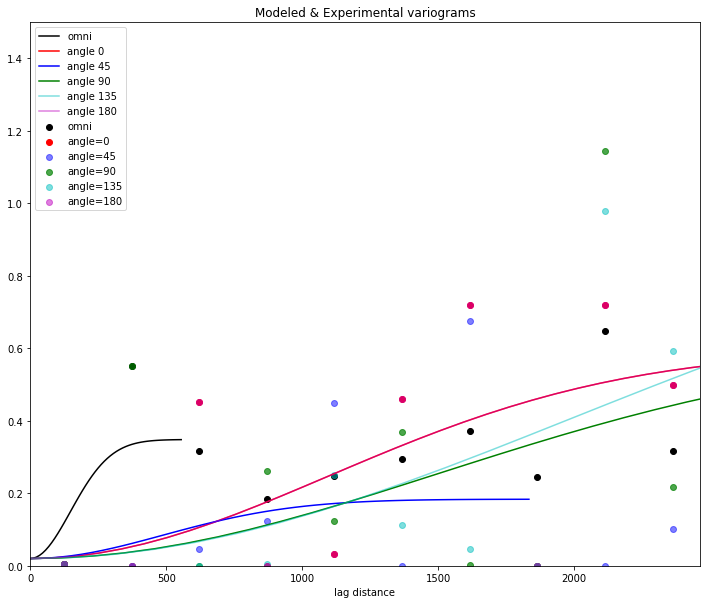

In [ ]:
fig, axes = plt.subplots(figsize=(12,10))

vario_model.plot(c='k', label='omni',ax=axes)
vario_model_0.plot(c='r', label='angle 0',ax=axes); print('vario_model_0',vario_model_0)
vario_model_45.plot(c='b', label='angle 45',ax=axes); print('vario_model_45',vario_model_45)
vario_model_90.plot(c='g', label='angle 90',ax=axes); print('vario_model_90',vario_model_90)
vario_model_135.plot(c='c', label='angle 135',ax=axes,alpha=0.5); print('vario_model_135',vario_model_135)
vario_model_180.plot(c='m', label='angle 180',ax=axes,alpha=0.5);print('vario_model_180',vario_model_180)

axes.scatter(bin_center, gamma,c='k', label='omni')
axes.scatter(bin_center, gamma_0,c='r', label='angle=0')
axes.scatter(bin_center, gamma_45,c='b',label='angle=45',alpha=0.5)
axes.scatter(bin_center, gamma_90,c='g',label='angle=90',alpha=0.7)
axes.scatter(bin_center, gamma_135,c='c',label='angle=135',alpha=0.5)
axes.scatter(bin_center, gamma_180,c='m',label='angle=180',alpha=0.5)
axes.legend()
axes.set_xlabel('lag distance')
axes.set_xlim([0, np.max(bin_center)+100])
axes.set_ylim([0, 1.5])
#titletxt = str(vario_model)+' & Experimental variogram'
axes.set_title('Modeled & Experimental variograms')

<font color=red size=4> Which direction has the longest spatial correlation?

In [ ]:
all_fitted_1D = [vario_model_0, vario_model_45, vario_model_90, vario_model_135, vario_model_180]
all_fitted_1D 

[Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02, anis=[0.245]),
 Gaussian(dim=2, var=0.164, len_scale=6.11e+02, nugget=0.02, anis=[0.245], angles=[0.785]),
 Gaussian(dim=2, var=0.594, len_scale=1.88e+03, nugget=0.02, anis=[0.245], angles=[1.57]),
 Gaussian(dim=2, var=0.98, len_scale=2.49e+03, nugget=0.02, anis=[0.245], angles=[2.36]),
 Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02, anis=[0.245], angles=[3.14])]

In [ ]:
mydegrees

[0, 45, 90, 135, 180]

# Kriging with directional variograms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02, anis=[0.245])


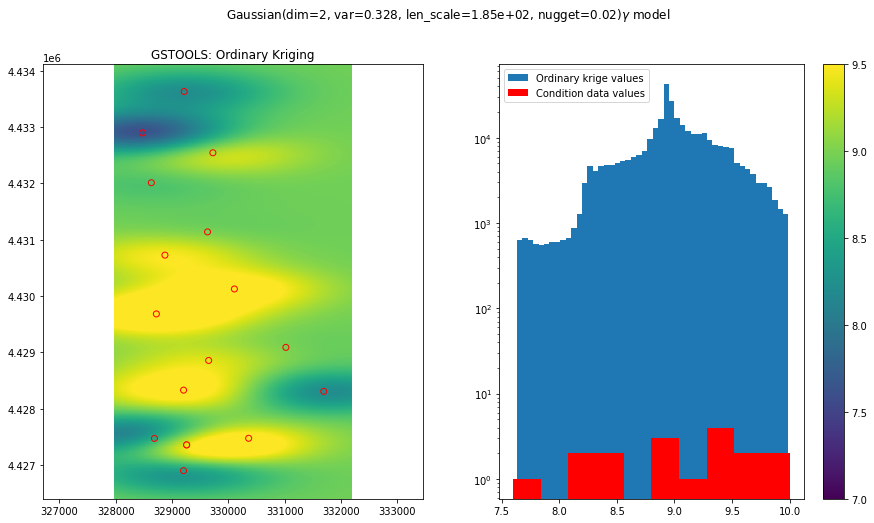

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.164, len_scale=6.11e+02, nugget=0.02, anis=[0.245], angles=[0.785])


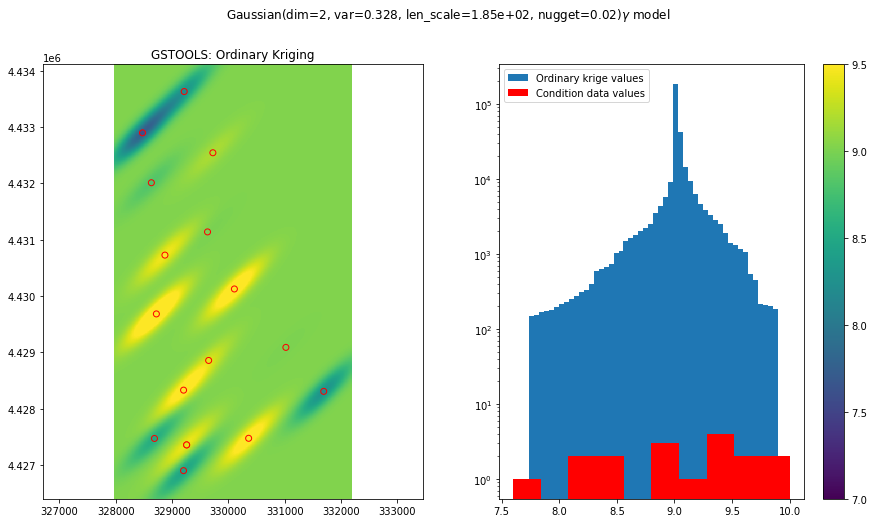

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.594, len_scale=1.88e+03, nugget=0.02, anis=[0.245], angles=[1.57])


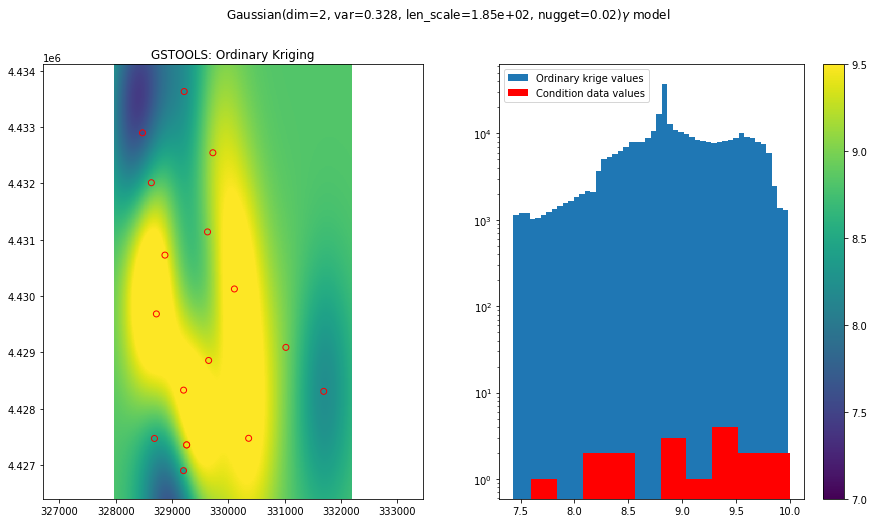

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.98, len_scale=2.49e+03, nugget=0.02, anis=[0.245], angles=[2.36])


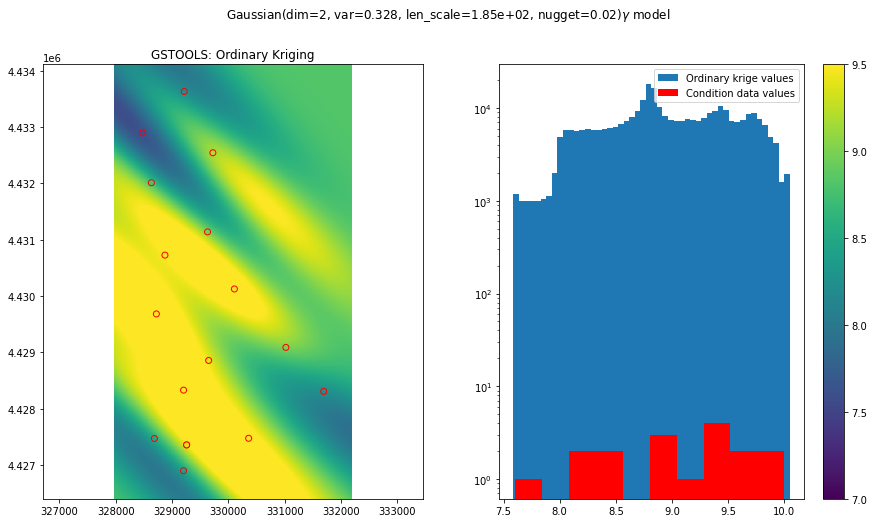

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

made with this variogram model:  Gaussian(dim=2, var=0.575, len_scale=1.37e+03, nugget=0.02, anis=[0.245], angles=[3.14])


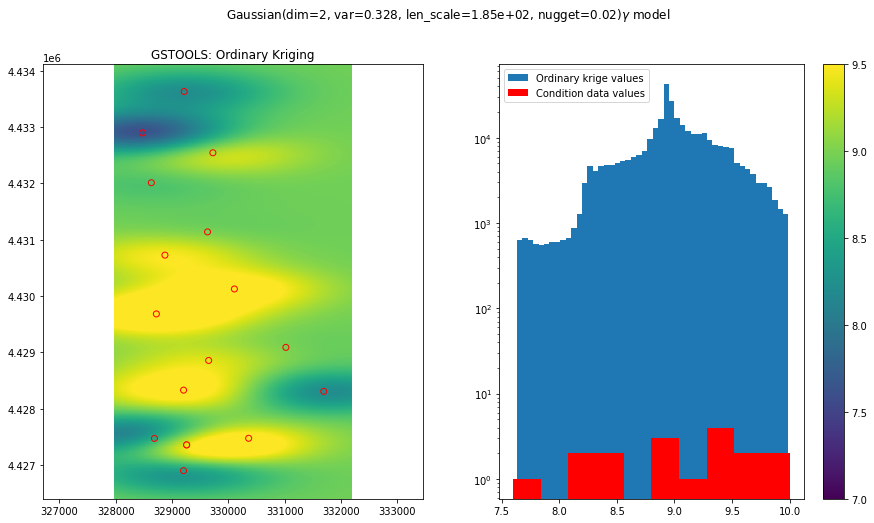

<IPython.core.display.Javascript object>

In [ ]:
if IN_COLAB:
    tb2 = widgets.TabBar(['2d Kriging with this continuity  '+str(mydegrees[i]) for i in range(np.shape(mydegrees)[0])])
else:
    ## local conda
    fig, myax = plt.subplots(figsize=[10,15],ncols = 2, nrows = np.shape(mydegrees)[0])
#     myax = myax.flatten()

for i in range(np.shape(mydegrees)[0]):

    ## Only select the first 2 tabs, and render others in the background.
    if IN_COLAB:
        with tb2.output_to(i, select=(i < 2)):

          vario_model_Krige = all_fitted_1D[i]
        
          krigeOK = gs.krige.Ordinary(vario_model_Krige, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
          krigeOK.structured((gridx, gridy))

          print('made with this variogram model: ',vario_model_Krige)
          np.shape(krigeOK.field)
          my_vmin = 7 # 10
          my_vmax = 9.5 #90

          f, myax = plt.subplots(figsize=[15, 8], nrows=1, ncols=2)
          myax = myax.flatten()
          # plot the result
          phandle =myax[0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[0].set_title('GSTOOLS: Ordinary Kriging')
          myax[0].axis('equal')
          cb = plt.colorbar(phandle)

          myax[1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[1].set_yscale('log')
          myax[1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          plt.suptitle(titletxt)
    else:

          vario_model_Krige = all_fitted_1D[i]
          print('made with this i, variogram model: ',i, vario_model_Krige)
          krigeOK = gs.krige.Ordinary(vario_model_Krige, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
          krigeOK.structured((gridx, gridy))

          np.shape(krigeOK.field)
          my_vmin = 7 # 10
          my_vmax = 9.5 #90
              # plot the result
          phandle =myax[i,0].pcolormesh(gridx,gridy,krigeOK.field.T,shading='auto',vmin=my_vmin, vmax=my_vmax,clip_on=True)
          myax[i,0].scatter(temp_cond_pos[0][0][:],temp_cond_pos[1][0][:],c=temp_cond_val,edgecolors='r', vmin=my_vmin, vmax=my_vmax)
          myax[i,0].set_title('GSTOOLS: Ordinary Kriging')
          myax[i,0].axis('equal')
          divider = make_axes_locatable(myax[i,0])  
          cax = divider.append_axes("right", size="5%", pad=0.1)  
          cb=plt.colorbar(phandle, cax=cax)

          myax[i,1].hist(krigeOK.field.flatten(),50,label='Ordinary krige values')
          myax[i,1].hist(temp_cond_val,color='red',label='Condition data values')
          myax[i,1].set_yscale('log')
          myax[i,1].legend()

          titletxt = str(vario_model)+'$\gamma$ model'
          myax[i,0].set_title(titletxt,fontsize=9)



<font size=4> Kinda hard to see the direction in it because the ranges are so widely different. <font color=red> Let's go back and fix the ranges to be the same AND add in anistropy by giving two: `len_scale = [2.41e+03, 6.99e+02]`. You should only have to uncomment these statements where the 2D directional variograms were initialized (UP 6 cells).

# Conditioned Random Field
Like Stochastic generation. This cell may take a little bit to run.

<font color=purple> Pick your favorite variogram:
```
[vario_model_0, vario_model_45, vario_model_90, vario_model_135, vario_model_180]
```

In [ ]:
krigeOK = gs.krige.Ordinary(vario_model_135, cond_pos=temp_cond_pos, cond_val=temp_cond_val, exact=True) 
krigeOK.structured((gridx, gridy))

cond_srf = gs.CondSRF(krigeOK)
cond_srf

CondSRF(krige=Ordinary(model=Gaussian, cond_no=17), generator=RandMeth)

In [ ]:
ens_no = 4
field = []
for i in range(ens_no): 
    field.append(cond_srf.structured([gridx, gridy],seed=i+49))

For plotting purposes, get the conditioning data on same scale as conditioned random field.

In [ ]:
# conditioning data on grid values
condgrid_x = np.floor((temp_df.x_easting-np.min(gridx))/10)
condgrid_y = np.floor((temp_df.y_northing-np.min(gridy))/10)

Plot all four *realizations* and the difference between each (so you see 0's along the diagonal.

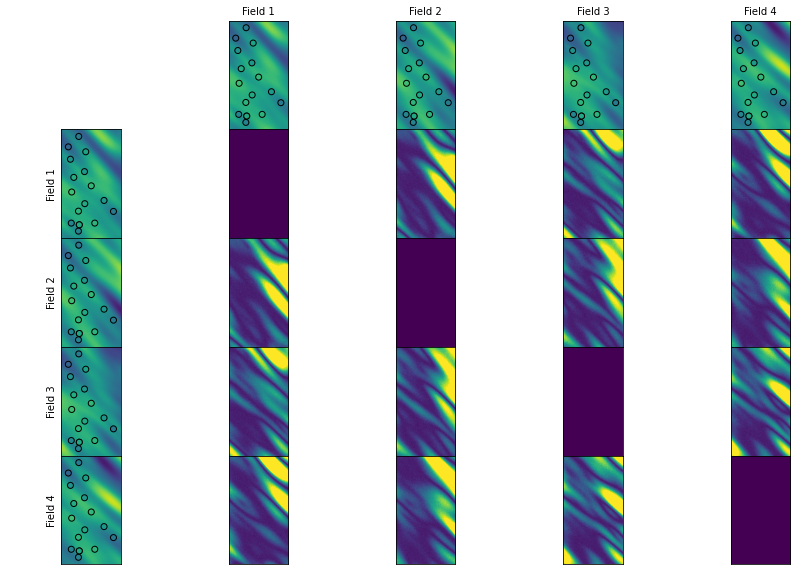

In [ ]:
fig, ax = plt.subplots(ens_no + 1, ens_no + 1, figsize=(15, 10))
# plotting kwargs for scatter and image
sc_kwargs = dict(c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))

#extent : floats (left, right, bottom, top), optional extent=2 * [0, 5], 
im_kwargs = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=np.min(field), vmax=np.max(field))
im_kwargs2 = dict(extent=[-0.5, np.shape(field)[1]-0.5,0,np.shape(field)[2]], origin="lower", vmin=0, vmax=2)

for i in range(ens_no):
      # conditioned fields and conditions
    ax[i + 1, 0].imshow(field[i].T , **im_kwargs)
    ax[i + 1, 0].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[i + 1, 0].set_ylabel(f"Field {i+1}", fontsize=10)
    ax[0, i + 1].imshow(field[i].T, **im_kwargs)
    ax[0, i + 1].scatter(condgrid_x,condgrid_y, **sc_kwargs)
    ax[0, i + 1].set_title(f"Field {i+1}", fontsize=10)
    # absolute differences
    for j in range(ens_no):
        ax[i + 1, j + 1].imshow(np.abs(field[i] - field[j]).T, **im_kwargs2)

# beautify plots
ax[0, 0].axis("off")
for a in ax.flatten():
    a.set_xticklabels([]), a.set_yticklabels([])
    a.set_xticks([]), a.set_yticks([])
    
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

Closer look

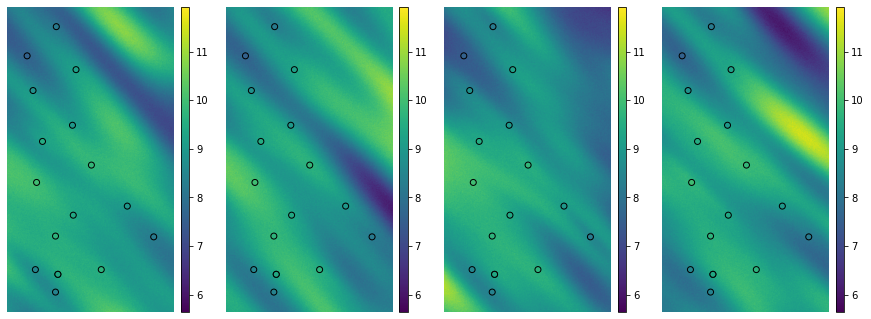

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(15,10))
axes = axes.flatten()

for i in range(ens_no):
    phandle = axes[i].imshow(field[i].T,**im_kwargs)
    axes[i].scatter(condgrid_x,condgrid_y, c=temp_cond_val, edgecolors="k", vmin=np.min(field), vmax=np.max(field))
    axes[i].axis('equal')
    axes[i].set_axis_off()
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = plt.colorbar(phandle,cax=cax)

# 3D Kriging for demonstration purposes

This data is actually from 2m probes (hence so low), but let's add some fake z data so you can see 3D Kriging and visualization with PyVista.

Here's an example of a function:

In [ ]:
import scipy.stats

Generate some random numbers, from a distribution that has a mean of 100, standard deviation of 30. We want as many fake z's as there are x's in our data (`len(temp_df.x)`)

In [ ]:
fake_z = scipy.stats.norm.rvs(100, 10, size=len(temp_df.x_easting)) 
fake_z

array([ 87.59622842, 112.11479113, 106.25806015, 115.25893576,
        77.28178517,  91.78330767,  99.58650048, 104.92267181,
       107.56473223,  97.68741928,  89.45681921,  91.72905867,
       116.05701071, 105.21133934, 104.99898105,  90.89291044,
       110.85297049])

In [ ]:
temp_df.z = fake_z

Make a new grid so that it's not too big...

In [ ]:
dx=200
dy=200
dz=10
gridx = np.arange(np.min(temp_df.x_easting), np.max(temp_df.x_easting),dx); print(np.shape(gridx))
gridy = np.arange(np.min(temp_df.y_northing), np.max(temp_df.y_northing),dy); print(np.shape(gridy))
gridz = np.arange(np.min(temp_df.z), np.max(temp_df.z),dz); print(np.shape(gridz))


(17,)
(34,)
(4,)


Re-fit variogram in 3d.

In [ ]:
temp_cond_pos_3d = [[temp_df.x_easting], [temp_df.y_northing], [temp_df.z]]

In [ ]:
bin_center_3d, dir_vario_3d, counts_3d = gs.vario_estimate(
*((temp_cond_pos_3d), temp_cond_val),
direction=gs.rotated_main_axes(dim=3, angles=1.57),
#angles_tol=np.pi / 8,
#bandwidth=8,
return_counts=True,
)

In [ ]:
vario_model_3d = gs.Gaussian(dim=3, len_scale=[2300, 1600], angles=1.57) 
print("Original:")
print(vario_model_3d)
vario_model_3d.fit_variogram(bin_center_3d, dir_vario_3d) #, nugget=True)

Original:
Gaussian(dim=3, var=1.0, len_scale=2.3e+03, nugget=0.0, anis=[0.696, 0.696], angles=[1.57, 0.0, 0.0])


({'anis': array([8.32634487e-01, 3.39070598e+04]),
  'len_scale': 1804.6427898659263,
  'nugget': 0.033636380939580386,
  'var': 0.6077110470751289},
 array([[ 2.00826239e-01,  4.86010083e+02,  3.78916291e-03,
          3.93780709e-02,  1.72442006e+10],
        [ 4.86010083e+02,  1.51053203e+06,  3.19663193e+01,
         -6.76821935e+00,  1.45476407e+14],
        [ 3.78916291e-03,  3.19663193e+01,  4.63126558e-03,
          6.67103722e-04,  2.10765582e+10],
        [ 3.93780709e-02, -6.76821935e+00,  6.67103722e-04,
          9.75186609e-02,  3.03594151e+09],
        [ 1.72442006e+10,  1.45476407e+14,  2.10765582e+10,
          3.03594151e+09,  6.94021003e+23]]))

In [ ]:
pos3 = [temp_df.x_easting.values,temp_df.y_northing.values,temp_df.z] # X Y Z
field3 = temp_df['2mCorr'] # temperature
print(np.shape(pos3),np.shape(field3))
normalizer = gs.normalizer.LogNormal
krige = gs.krige.Ordinary(vario_model_3d, pos3, field3)#, normalizer=normalizer)
krige.structured((gridx, gridy, gridz))
print('size of kriging estimate',krige.field.shape)

(3, 17) (17,)
size of kriging estimate (17, 34, 4)


## Stuff to let PyVista work on colab

In [ ]:
if IN_COLAB:
    !pip install -q piglet pyvirtualdisplay
    !pip install -q pyvista
    !apt-get -qq install xvfb


     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 1.4 MB 23.1 MB/s 
     |████████████████████████████████| 88.3 MB 103 kB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 66.4 MB/s 
     |████████████████████████████████| 271 kB 64.0 MB/s 
Selecting previously unselected package xvfb.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
if IN_COLAB:
    # !pip install pythreejs
    !pip install ipyvtklink

     |████████████████████████████████| 255 kB 28.3 MB/s 


In [ ]:
if IN_COLAB:
    # setup environment for interactive plotting
    !apt-get install -qq xvfb
    !pip install pyvista panel -q

import os
if IN_COLAB:
    os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
    os.environ['DISPLAY'] = ':99'

    # import panel as pn
    # pn.extension('vtk')


In [ ]:
if IN_COLAB:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(600, 400))
    display.start()



In [ ]:
# new cell
import pyvista as pv
# pv.set_jupyter_backend('pythreejs')
pv.set_jupyter_backend('ipyvtklink')

In [ ]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

In [ ]:
# from google.colab import output
# output.disable_custom_widget_manager()

In [ ]:
# pv.global_theme.background = 'white'
# pv.global_theme.antialiasing = True
pv.set_plot_theme("document")

Just a test of the display (nothing from our data or modeling)

In [ ]:
sphere = pv.Sphere()
# short example
sphere.plot(notebook=True, window_size=(600,400))
plt.show()

## Putting the 3d kriging values into PyVista object

In [ ]:
# https://docs.pyvista.org/examples/00-load/create-uniform-grid.html
values = krige.field

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (dx, dy, dz)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array!


Now plotting!

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Now plot the grid!
grid.plot(notebook=True, window_size=(600,400),show_edges=False) #show_bounds=True

In [ ]:
# Now plot the grid!
IP = pv.Plotter()
IP.add_mesh(grid,opacity=0.6) #plot(notebook=True, window_size=(600,400),show_edges=False) #show_bounds=True
IP.set_scale(zscale=2)
IP.add_axes()
IP.show()

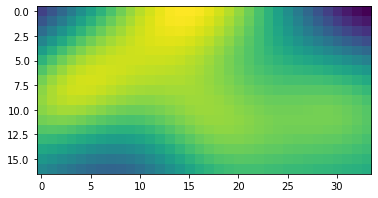

In [ ]:
plt.imshow(krige.field[:,:,0])

# More resources

If you are familiar with Scikit-Learn
- scikit-gstat: A scipy flavoured geostatistical variogram analysis toolbox
    - `!pip install scikit-gstat`

If you have Microsoft operation system (not a Mac or Linux), you can try 
- [Stanford Geostatistcal Modeling Software- SGEMS](http://sgems.sourceforge.net/)
    - has SGSIM, multiple point geostatistics, indicator kriging/simulation, etc.
- [PyGeostat](http://www.ccgalberta.com/pygeostat/installation.html)
    - calls GSLib functions

GeostatsPy also calls GSLib functions but has work arounds for Mac's.
- [GeostatsPy](https://www.michaelpyrcz.com/my-python-package.html)
    


